In [2]:
from google.colab import drive
drive.mount('/content/gdrive')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from sklearn.metrics import roc_auc_score

In [4]:
# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [5]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [6]:
# relevant file path
PROJECT_FOLDER = '/content/gdrive/MyDrive/PythonWork_Learning/Lazy_programmer/Deep-Learning-in-Python/'
TRAIN_DATA = os.path.join(PROJECT_FOLDER, 'large_files','jigsaw-toxic-comment-classification-challenge' ,'train.csv')
GLOVE_FILE = os.path.join(PROJECT_FOLDER, 'large_files', 'glove.6B', f'glove.6B.{EMBEDDING_DIM}d.txt')

In [7]:
''' 
TODO 
look at a histogram of each comment length, to make sure whatever max_sequence_lengh you chose is reasonable
prepare glove.6B.100d.txt (or 200d) 
check the trian dataset by pandas
remove stop words
remove numbers
do it with tf2 generator
'''

' \nTODO \nlook at a histogram of each comment length, to make sure whatever max_sequence_lengh you chose is reasonable\nprepare glove.6B.100d.txt (or 200d) \ncheck the trian dataset by pandas\nremove stop words\nremove numbers\ndo it with tf2 generator\n'

In [8]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(GLOVE_FILE) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.array(values[1:], dtype=np.float32)
    word2vec[word] = vec
  
print(f"Found {len(word2vec)} word vectors")


Loading word vectors...
Found 400000 word vectors


In [9]:
# prepare text samples and their labels
train = pd.read_csv(TRAIN_DATA)
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [10]:
# prepare text samples and their labels
print('Loading in comments')

train = pd.read_csv(TRAIN_DATA)
sentences = train['comment_text'].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values


Loading in comments


In [11]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [12]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("medium sequence length:", s[len(s) // 2])
print('max word index: ', max(max(seq) for seq in sequences if len(seq) > 0))

max sequence length: 1400
min sequence length: 0
medium sequence length: 35
max word index:  19999


In [13]:
word2idx = tokenizer.word_index # idx start form 1, and 順序會從高頻字到低頻字, 在keras中 index=0 是留給padding 使用的
print(f'Found {len(word2idx)} unique tokens')

Found 210337 unique tokens


In [14]:
# pad sequence so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('shape of data tensor:', data.shape)

shape of data tensor: (159571, 100)


In [15]:
# prepare embedding matrix
print("Filling pre-trained embeddings...")
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in tqdm(word2idx.items()):
  if i < num_words:
    embedding_vector = word2vec.get(word) # return None if word coundn't find in word2vec
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


100%|██████████| 210337/210337 [00:00<00:00, 1667925.16it/s]

Filling pre-trained embeddings...


In [16]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words, 
    EMBEDDING_DIM, 
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH, 
    trainable=False
)


In [24]:
print('Building model...')
# train a 1D convent with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

callbacks = [
  tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(PROJECT_FOLDER, 'nlp_class3', 'cnn_toxic_model.h5'),
      save_weight_only=True, 
      monitor='val_loss'
  )
]

model.summary()

Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 30, 128)           49280     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 10, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 12

In [25]:
print('Training model...')
r = model.fit(
    data,
    targets, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=VALIDATION_SPLIT,
    verbose=2, 
    callbacks=callbacks
)


Training model...
Epoch 1/10
998/998 - 7s - loss: 0.0835 - accuracy: 0.9820 - val_loss: 0.0752 - val_accuracy: 0.9941
Epoch 2/10
998/998 - 6s - loss: 0.0675 - accuracy: 0.9924 - val_loss: 0.0679 - val_accuracy: 0.9915
Epoch 3/10
998/998 - 6s - loss: 0.0629 - accuracy: 0.9918 - val_loss: 0.0753 - val_accuracy: 0.9941
Epoch 4/10
998/998 - 6s - loss: 0.0599 - accuracy: 0.9928 - val_loss: 0.0687 - val_accuracy: 0.9941
Epoch 5/10
998/998 - 6s - loss: 0.0574 - accuracy: 0.9930 - val_loss: 0.0684 - val_accuracy: 0.9938
Epoch 6/10
998/998 - 6s - loss: 0.0552 - accuracy: 0.9934 - val_loss: 0.0789 - val_accuracy: 0.9908
Epoch 7/10
998/998 - 6s - loss: 0.0536 - accuracy: 0.9936 - val_loss: 0.0738 - val_accuracy: 0.9919
Epoch 8/10
998/998 - 6s - loss: 0.0525 - accuracy: 0.9936 - val_loss: 0.0904 - val_accuracy: 0.9941
Epoch 9/10
998/998 - 6s - loss: 0.0509 - accuracy: 0.9932 - val_loss: 0.1447 - val_accuracy: 0.9930
Epoch 10/10
998/998 - 6s - loss: 0.0503 - accuracy: 0.9934 - val_loss: 0.0901 - va

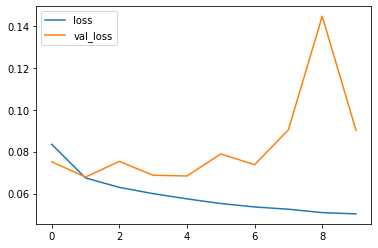

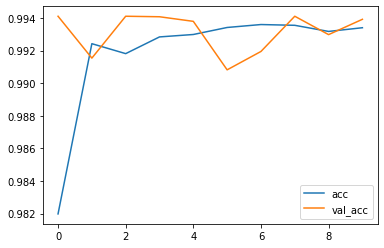

In [26]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [27]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9755570500778618


In [34]:
p[:,1]

array([2.4094465e-10, 5.9464391e-12, 1.3419828e-10, ..., 7.4187306e-10,
       1.7865251e-08, 1.6022207e-04], dtype=float32)

In [31]:
p[0]

array([7.5594278e-04, 2.4094465e-10, 8.0978214e-05, 8.5258920e-09,
       3.9586612e-05, 5.8518714e-07], dtype=float32)

In [ ]:
# rebuild model
infer_model = Model(input_, output)
infer_model.load_weights(os.path.join(PROJECT_FOLDER, 'nlp_class3', 'cnn_toxic_model.h5'))